# Registration Experimentation
This Jupyter Notebook evaluates various registration techniques in the development of an animal study pipeline. Babak Ardekani's ART toolset will be employed here with various parameters.

The primary benefit of processing with this script is the conversion of local absolute paths to Docker-filesystem paths, i.e. local paths are auto-modified to Docker mount paths.

## Import Modules
This section imports various Python modules to process and analyze data for evaluation. The modules being used are responsible for the following functions:
1. subprocess: execute system commands
2. os: manipulate OS-related things
4. numpy: manage and manipulate nifti images as arrays
3. nibabel: read nifti files
4. matplotlib: visualize nifti images

In [1]:
import subprocess
import os
import os.path as op
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

## Docker Configuration
**Required:** Please configure this section to match your Docker image for ARTDock.

In [2]:
docker_tag = 'artdock:latest'
docker_mount = '/Users/sid/Downloads/Mouse/data'
docker_mountpoint = '/data'
docker_command = '3dwarper'

## Path to Files
Define path to various files. There are two types of files to consider:
1. Target: template to register images to
2. Moving: image that will be registered to template

Please enter absolute paths from your host system only.

In [3]:
# Target image
trgPath = '/Users/sid/Downloads/Mouse/data/same_mice_Time1,2/w1t1m8/ACQ_BRUKER_PVMTurboRARE-T2X4P1.nii'

# Moving image
movPath = '/Users/sid/Downloads/Mouse/data/same_mice_Time1,2/w1t2m8/ACQ_BRUKER_PVMTurboRARE-T2X4P1.nii'

# Output Path
outPath = '/Users/sid/Downloads/Mouse/data/out'

### Build Docker Paths
This section uses paths defined for Docker and files to construct mountpounts for inputs and outputs such that they appear to be mounted within a Docker container.

In [4]:
# Separate docker mount path
dockerMountList = [i for i in docker_mount.split(op.sep) if i]

# Separate path to target
trgPathList = [i for i in trgPath.split(op.sep) if i]
trgPathList = [x for x in trgPathList if x not in dockerMountList]
trgPathD = op.sep.join(trgPathList)
trgPathD = op.join(docker_mountpoint, trgPathD)

# Seperate path to moving
movPathList = [i for i in movPath.split(op.sep) if i]
movPathList = [x for x in movPathList if x not in dockerMountList]
movPathD = op.sep.join(movPathList)
movPathD = op.join(docker_mountpoint, movPathD)

# Separate path to out
outPathList = [i for i in outPath.split(op.sep) if i]
outPathList = [x for x in outPathList if x not in dockerMountList]
outPathD = op.sep.join(outPathList)
outPathD = op.join(docker_mountpoint, outPathD)

print(trgPathD)
print(movPathD)
print(outPathD)

/data/same_mice_Time1,2/w1t1m8/ACQ_BRUKER_PVMTurboRARE-T2X4P1.nii
/data/same_mice_Time1,2/w1t2m8/ACQ_BRUKER_PVMTurboRARE-T2X4P1.nii
/data/out


## Execute Registration
This section calls the ARTDock container and runs ART tools to register the moving image to target template using T2.

In [60]:
# Construct docker command
reg_arg = ['docker', 'run', '-t', '--rm']
# Manage volume mounting
reg_arg.extend(['-v', docker_mount + ':' + docker_mountpoint])
# Execute docker_tag
reg_arg.extend([docker_tag, docker_command])
# Build processing command
reg_arg.extend(['-v'])
reg_arg.extend(['-iter', '15'])
# reg_arg.extend(['-A'])
reg_arg.extend(['-o', op.join(outPathD, 'art_output.nii')])
reg_arg.extend(['-u', op.join(outPathD, 'art_output_wrp.nii')])
reg_arg.extend(['-sub', movPathD])
reg_arg.extend(['-trg', trgPathD])
print('Executing command: ' + ' '.join(reg_arg))
completion = subprocess.run(reg_arg)
if completion.returncode != 0:
    raise Exception('Failed to run docker image {}'.format(docker_tag))

Executing command: docker run -t --rm -v /Users/sid/Downloads/Mouse/data:/data artdock:latest 3dwarper -v -iter 15 -o /data/out/art_output.nii -u /data/out/art_output_wrp.nii -sub /data/same_mice_Time1,2/w1t2m8/ACQ_BRUKER_PVMTurboRARE-T2X4P1.nii -trg /data/same_mice_Time1,2/w1t1m8/ACQ_BRUKER_PVMTurboRARE-T2X4P1.nii


## View Registration Results
This section opens and plots the image to demonstrate registration results

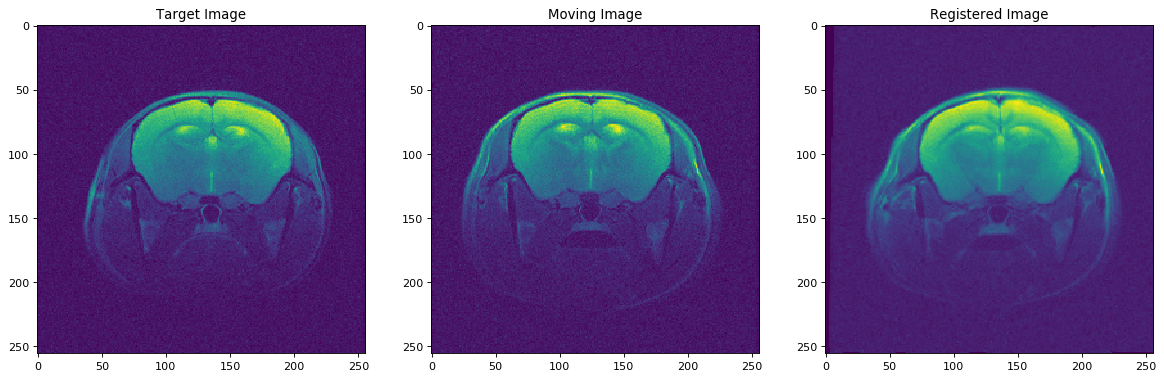

In [49]:
# Load images
slice = 8 # slice to view
trgImg = np.rot90(np.array(nib.load(trgPath).dataobj), 3, (0,1))               
movImg = np.rot90(np.array(nib.load(movPath).dataobj), 3, (0,1))
outImg = np.rot90(np.array(nib.load(op.join(outPath, 'art_output.nii')).dataobj), 3, (0,1))

# Create figure
fig = plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
a = fig.add_subplot(1, 3, 1)
imgplot = plt.imshow(trgImg[:,:,slice])
a.set_title('Target Image')
b = fig.add_subplot(1, 3, 2)
imgplot = plt.imshow(movImg[:,:,slice])
b.set_title('Moving Image')
c = fig.add_subplot(1, 3, 3)
imgplot = plt.imshow(outImg[:,:,slice])
c.set_title('Registered Image')
plt.show()

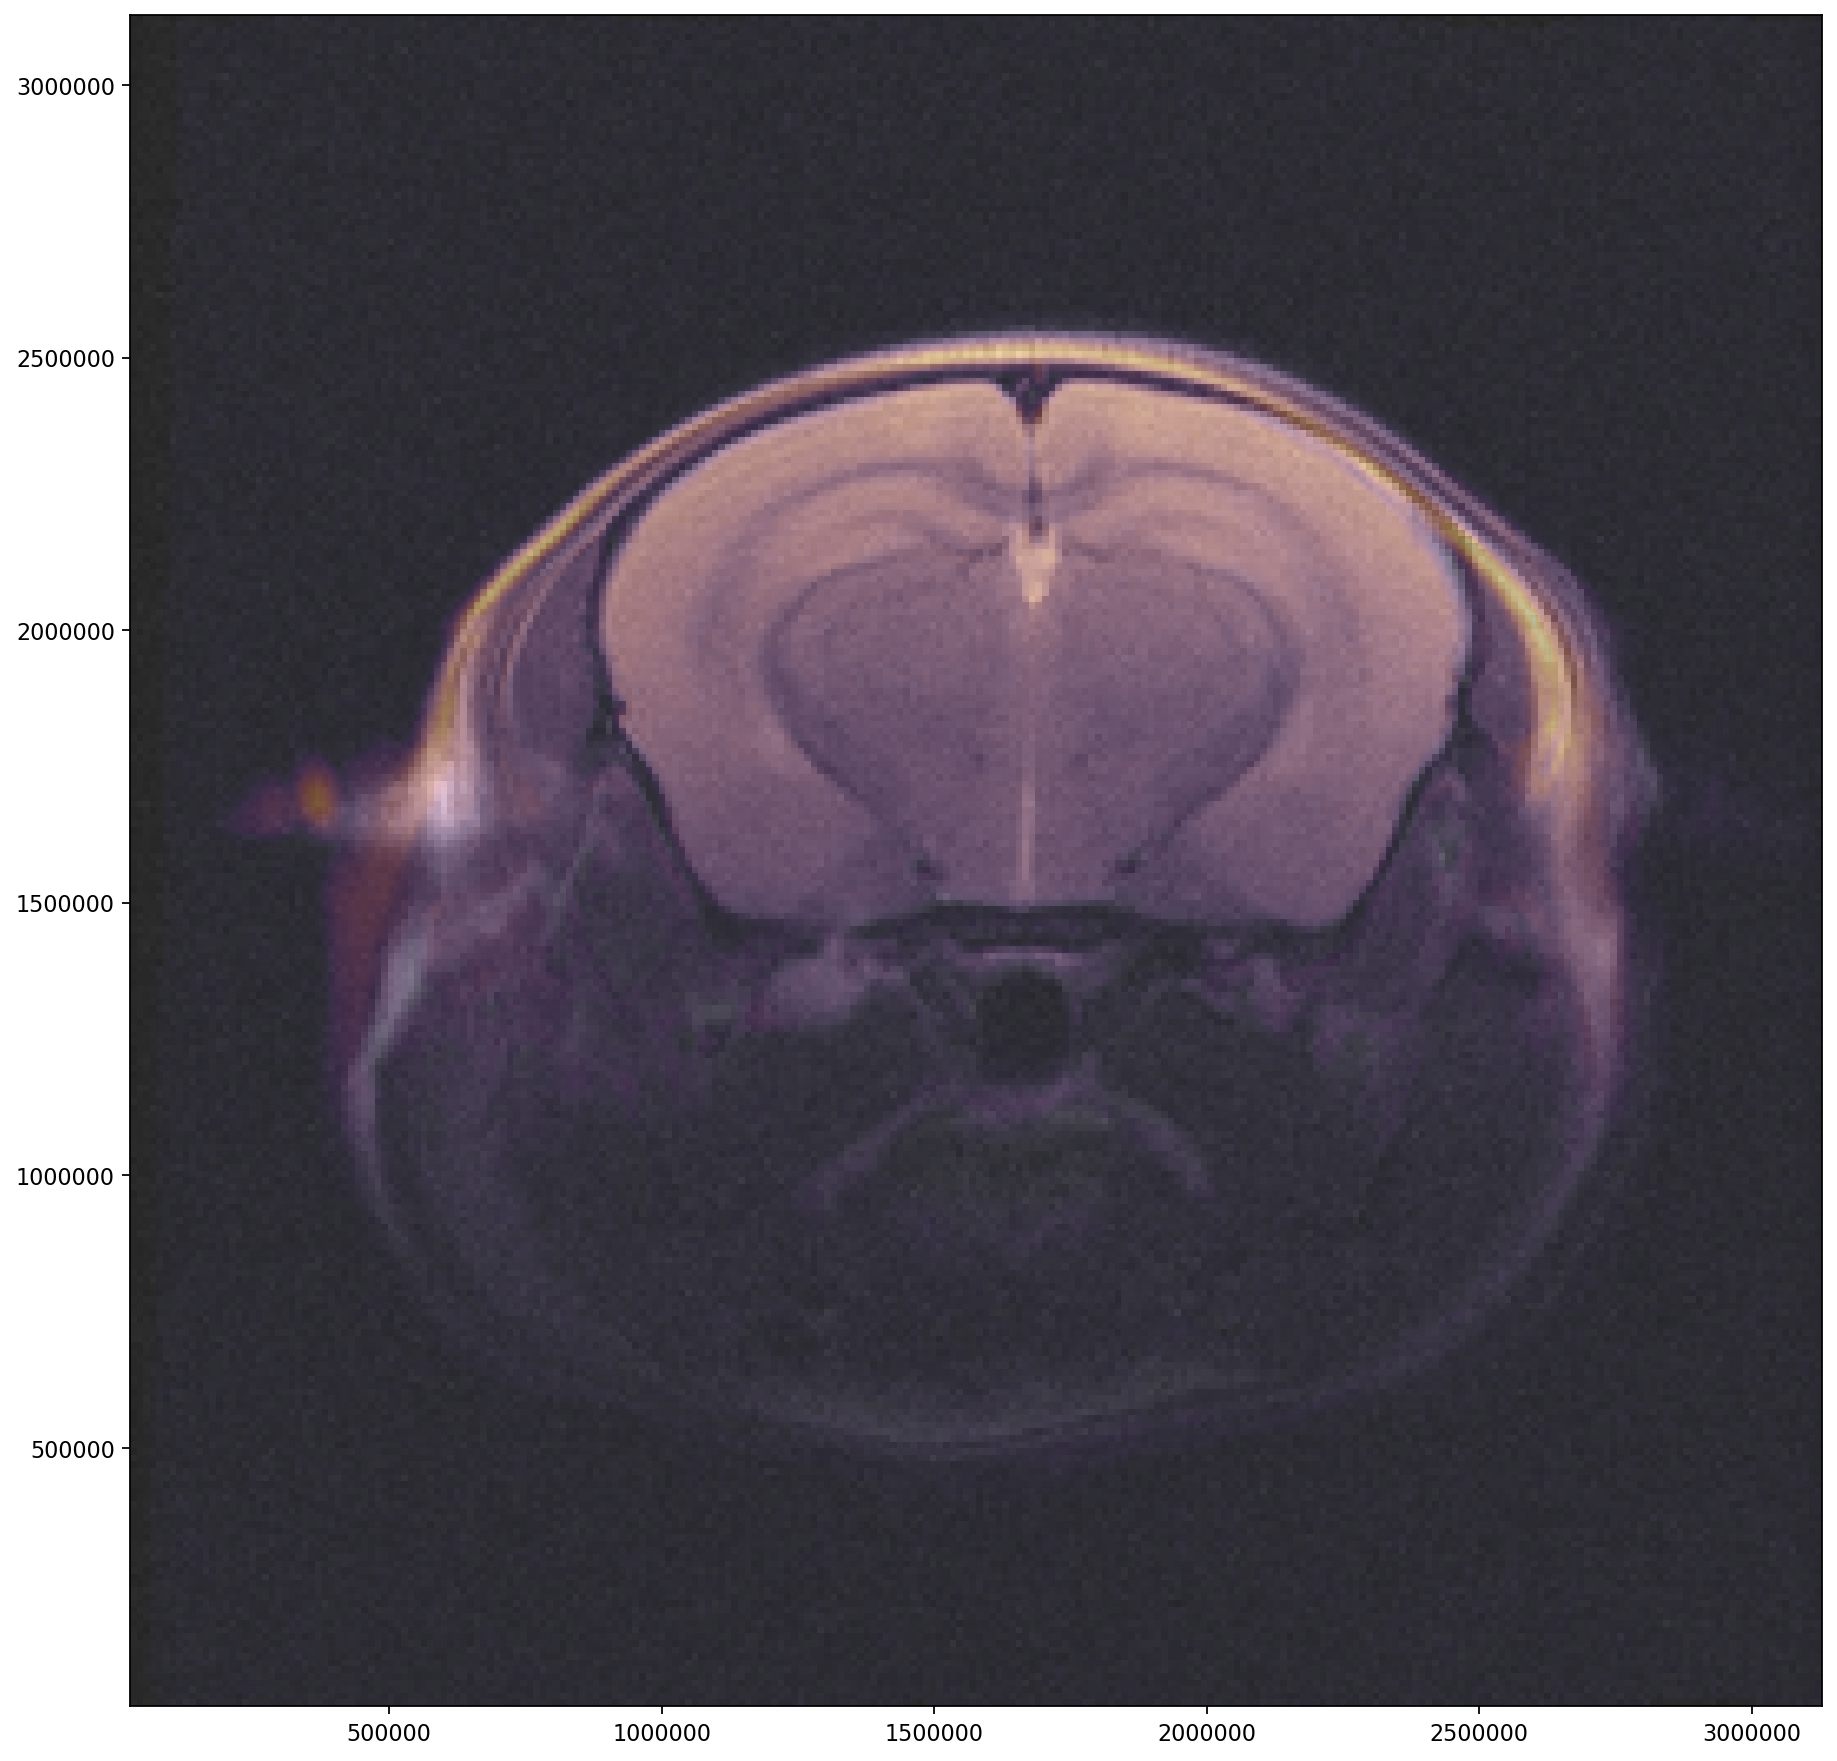

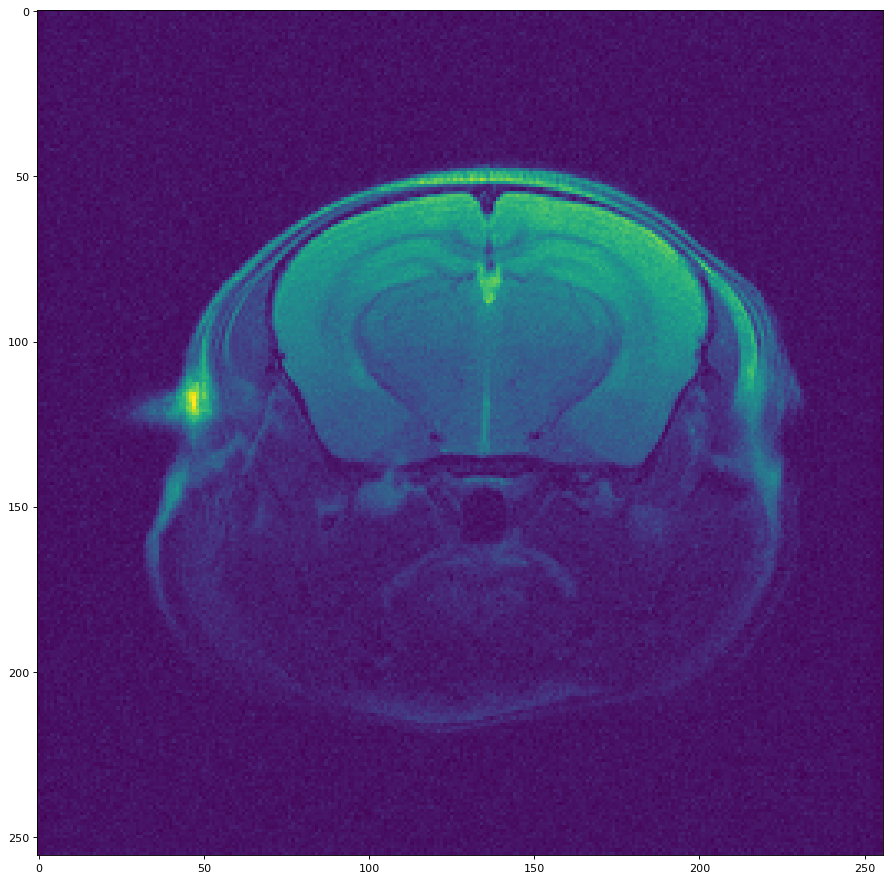

In [59]:
# Plot Overlay
fig = plt.figure(figsize=(16, 14), dpi= 160, facecolor='w', edgecolor='k')
extent = np.min(trgImg[:,:,slice]), np.max(trgImg[:,:,slice]), np.min(trgImg[:,:,slice]), np.max(trgImg[:,:,slice])
im1 = plt.imshow(trgImg[:,:,slice], cmap=plt.cm.gray, alpha=0.8, interpolation='nearest',
                 extent=extent)
# extent = np.min(outImg[:,:,slice]), np.max(outImg[:,:,slice]), np.min(outImg[:,:,slice]), np.max(outImg[:,:,slice])
im2 = plt.imshow(outImg[:,:,slice], cmap=plt.cm.inferno, alpha=0.3, interpolation='bilinear',
                extent=extent)
plt.show()



# Load displacement field
slice = 6 # slice to view
wrpImg = np.array(nib.load(op.join(outPath, 'art_output_wrp.nii')).dataobj)

fig = plt.figure(figsize=(16, 14), dpi= 80, facecolor='w', edgecolor='k')
imgplot = plt.imshow(trgImg[:,:,slice])